In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson

# Environment

## Logit environment

In [100]:
class AdversarialPricingEnvironment_Logit:
    def __init__(self, max_price=1.0, noise_level=0):
        self.max_price = max_price
        self.noise_level = noise_level
        np.random.seed(42)

    def generate_data(self, n_points=100, beta_parameter=-5):
        prices = np.linspace(0, self.max_price, n_points)
        
        # Beta will be our parameter
        alpha = 1
        purchase_probabilities = 1 / (1 + np.exp(-(alpha + beta_parameter * prices)))    
        
        # Noise
        noisy_purchase_probabilities = purchase_probabilities + np.random.normal(0, self.noise_level, n_points)
        
        # purchase probability in [0,1]
        noisy_purchase_probabilities = np.clip(noisy_purchase_probabilities, 0, 1)
        
        return prices.reshape(-1, 1), noisy_purchase_probabilities

    def simulate_jumps(self, mu = 4): # Default mu = 4 since it's the number of seasons (so we'll observe a year)
        # Jumps number from a Poisson with mean mu
        num_jumps = np.random.poisson(mu)
        
        # Jump lengths from an normal -> 90 is more or less one season lenght
        jump_lengths = np.round(np.random.normal(loc=90, scale=5, size=num_jumps)) 
        
        # Time Horizon
        T = int(jump_lengths.sum()) # So built you will se num_jums-1 effctivly jumps
        
        return num_jumps, jump_lengths, T

## Linear environment

In [86]:
class AdversarialPricingEnvironment_Linear:
    def __init__(self, max_price=1.0, noise_level=0):
        self.max_price = max_price
        self.noise_level = noise_level
        np.random.seed(42)

    def generate_data(self, n_points=100, p_parameter = 1): # p will be our parameter (default simple linear environment)
        prices = np.linspace(0, self.max_price, n_points)

        # Beta will be our parameter
        alpha = 1
        beta = 1
        purchase_probabilities = p_parameter*(alpha - beta*prices)  
        
        # Noise
        noisy_purchase_probabilities = purchase_probabilities + np.random.normal(0, self.noise_level, n_points)
        
        # purchase probability in [0,1]
        noisy_purchase_probabilities = np.clip(noisy_purchase_probabilities, 0, 1)
        
        return prices.reshape(-1, 1), noisy_purchase_probabilities
        

    def simulate_jumps(self, mu = 4): # Default mu = 4 since it's the number of seasons (so we'll observe a year)
        # Jumps number from a Poisson with mean mu
        num_jumps = np.random.poisson(mu)
        
        # Jump lengths from an normal -> 90 is more or less one season lenght
        jump_lengths = np.round(np.random.normal(loc=90, scale=5, size=num_jumps)) 
        
        # Time Horizon
        T = int(jump_lengths.sum()) # So built you will se num_jums-1 effctivly jumps
        
        return num_jumps, jump_lengths, T

# UCB1

In [17]:
class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

## Test on the logit environment

### Close to the stochastic setting (S = 0.5, s = 0.01)

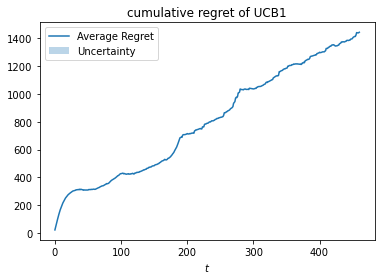

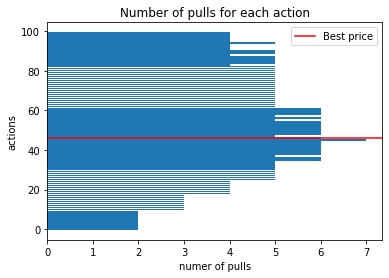

In [91]:
n_points = 100  # actions number 
cost = 0.2
n_customers = 200
max_price = 1.0

env = AdversarialPricingEnvironment_Logit(max_price=1.0, noise_level=0)
num_jumps, jump_lengths, T = env.simulate_jumps()

K = n_points
n_days = T

prices = np.linspace(0, max_price, n_points)


# Data generation -> each day the env samples for the prices of 'prices' the purchase probability, that is choosen randomly each day

prices_matrix = np.empty((n_days, n_points))  # Matrix to store prices for each day
probabilities_matrix = np.empty((n_days, n_points))  # Matrix to store purchase probabilities for each day
customers_number_matrix = np.empty((n_days, n_points))
rewards_matrix = np.empty((n_days, n_points))


# Loop through all the days
beta_parameters = np.array([-5]) # starting value for beta is -5
S = 0.5 # Varianace of the Normal for the beta_parameter variations during shock days 
s = 0.01 # Varianace of the Normal for the beta_parameter variations during normal days
jump_days = np.cumsum(jump_lengths)

for day in range(n_days):
    # Verify if it's a shock day
    if day in jump_days:
        beta_parameter_variation = np.random.normal(0, S)  # Varianza grande per gli shock
        beta_parameter = beta_parameters[-1] + beta_parameter_variation
    else:
        beta_parameter_variation = np.random.normal(0, s)  # Varianza piccola per i giorni normali
        beta_parameter = beta_parameters[-1] + beta_parameter_variation

    beta_parameters = np.append(beta_parameters, beta_parameter)
    # Data generation for the new beta
    day_prices, day_probabilities = env.generate_data(n_points, beta_parameter=beta_parameters[-1])
    
    # Price and probabilities memorization
    prices_matrix[day] = day_prices[:, 0]  
    probabilities_matrix[day] = day_probabilities  

# Probabilities_matrix -> customers_numbers -> rewards_matrix -> loss_seq
for i in range(n_days):
        for j in range(n_points):
            customers_number_matrix[i, j] = np.random.binomial(n_customers, probabilities_matrix[i, j])
            rewards_matrix[i, j] = customers_number_matrix[i, j]*(prices[j] - cost) # (Customers for that price (j) sampled in that day (i))*(that price(j) - cost)


best_arm_index = np.argmax(rewards_matrix.sum(axis=0))
best_arm = prices[best_arm_index]
clairvoyant_rewards = rewards_matrix[:, best_arm_index]

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    ucb_agent = UCB1Agent(K, T, range=15)

    agent_rewards = np.array([])

    for t in range(T):
        pi_t = ucb_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        r_t = rewards_matrix[t, pi_t]
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(100), ucb_agent.N_pulls)
plt.axhline(best_arm_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

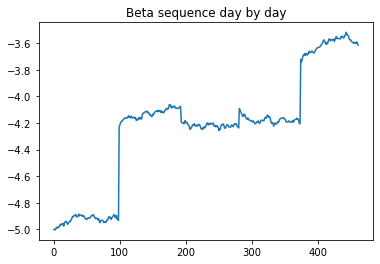

Beta: -4.934299697966296
Beta: -4.075546210998509
Beta: -4.238075624098074
Beta: -4.205259843482002
Beta: -3.615765757846199


In [92]:
# History of the beta parameter
plt.figure()
plt.plot(np.linspace(0, n_days, n_days+1),beta_parameters)
plt.title('Beta sequence day by day')
plt.show()


# Values of beta in the jumps
for jump_day in jump_days:
    print(f'Beta: {beta_parameters[int(jump_day)]}')

In [99]:
# Changes in the purchase probability function
def PurchaseProbabilityLogit_plot(beta_parameters, jump_days):
    n_points = 100
    prices = np.linspace(0, 1, n_points)
    alpha = 1
    
    # Calcola il numero totale di subplot
    num_subplots = len(jump_days)
     
    # Crea la figura e gli assi dei subplot
    fig, axes = plt.subplots(1, num_subplots, figsize=(20, 5))
    axes = axes.flatten() 
    
    for i, jump_day in enumerate(jump_days):
        # Calcola le probabilità di acquisto usando il corrispondente beta_parameter per l'indice jump_day
        purchase_probabilities = 1 / (1 + np.exp(-(alpha + beta_parameters[int(jump_day)] * prices)))    
        
        # Traccia il grafico
        ax = axes[i]
        ax.plot(prices, purchase_probabilities)
        ax.set_title(f'Beta Parameter: {beta_parameters[int(jump_day)]}')
        ax.set_xlabel('Prices')
        ax.set_ylabel('Purchase Probabilities')

    # Aggiusta il layout
    plt.tight_layout()
    plt.show()     

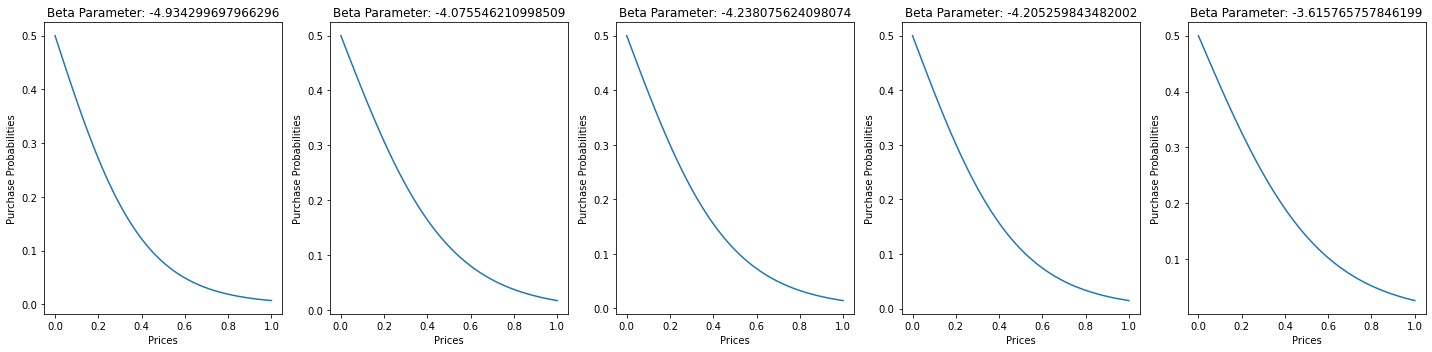

In [94]:
# Plot of the purchase probability when beta jumps
PurchaseProbabilityLogit_plot(beta_parameters, jump_days)

**Comment:**  
Choosing S = 0.5 (as variance for the normal used for the jumps) and s = 0.01 (as variance for the normal used for the small perturbation on the normal days) the purchase probability doesn't change that much, so even though we've jumps this environment is more close to the stochastic setting than the adversarial one, this is probably the reason why UCB1 still work pretty good.

### Towards the adversarial setting (S = 1, s = 0.01)

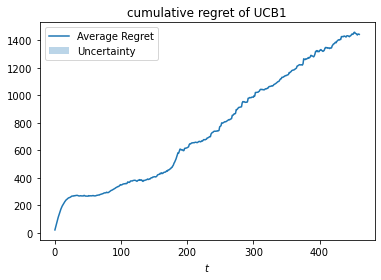

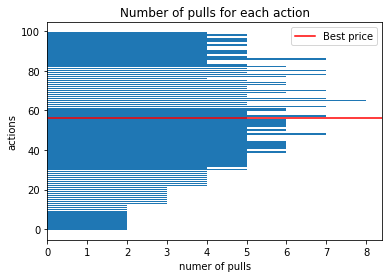

In [95]:
n_points = 100  # actions number 
cost = 0.2
n_customers = 200
max_price = 1.0

env = AdversarialPricingEnvironment_Logit(max_price=1.0, noise_level=0)
num_jumps, jump_lengths, T = env.simulate_jumps()

K = n_points
n_days = T

prices = np.linspace(0, max_price, n_points)


# Data generation -> each day the env samples for the prices of 'prices' the purchase probability, that is choosen randomly each day

prices_matrix = np.empty((n_days, n_points))  # Matrix to store prices for each day
probabilities_matrix = np.empty((n_days, n_points))  # Matrix to store purchase probabilities for each day
customers_number_matrix = np.empty((n_days, n_points))
rewards_matrix = np.empty((n_days, n_points))


# Loop through all the days
beta_parameters = np.array([-5]) # starting value for beta is -5
S = 1 # Varianace of the Normal for the beta_parameter variations during shock days 
s = 0.01 # Varianace of the Normal for the beta_parameter variations during normal days
jump_days = np.cumsum(jump_lengths)

for day in range(n_days):
    # Verify if it's a shock day
    if day in jump_days:
        beta_parameter_variation = np.random.normal(0, S)  # Varianza grande per gli shock
        beta_parameter = beta_parameters[-1] + beta_parameter_variation
    else:
        beta_parameter_variation = np.random.normal(0, s)  # Varianza piccola per i giorni normali
        beta_parameter = beta_parameters[-1] + beta_parameter_variation

    beta_parameters = np.append(beta_parameters, beta_parameter)
    # Data generation for the new beta
    day_prices, day_probabilities = env.generate_data(n_points, beta_parameter=beta_parameters[-1])
    
    # Price and probabilities memorization
    prices_matrix[day] = day_prices[:, 0]  
    probabilities_matrix[day] = day_probabilities  

# Probabilities_matrix -> customers_numbers -> rewards_matrix -> loss_seq
for i in range(n_days):
        for j in range(n_points):
            customers_number_matrix[i, j] = np.random.binomial(n_customers, probabilities_matrix[i, j])
            rewards_matrix[i, j] = customers_number_matrix[i, j]*(prices[j] - cost) # (Customers for that price (j) sampled in that day (i))*(that price(j) - cost)


best_arm_index = np.argmax(rewards_matrix.sum(axis=0))
best_arm = prices[best_arm_index]
clairvoyant_rewards = rewards_matrix[:, best_arm_index]

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    ucb_agent = UCB1Agent(K, T, range=15)

    agent_rewards = np.array([])

    for t in range(T):
        pi_t = ucb_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        r_t = rewards_matrix[t, pi_t]
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(100), ucb_agent.N_pulls)
plt.axhline(best_arm_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

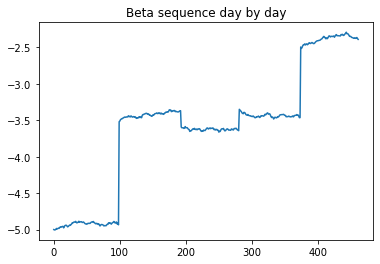

Beta: -4.934299697966296
Beta: -3.3685316432175125
Beta: -3.6428145864653327
Beta: -3.4635161589177175
Beta: -2.3896786513796595


In [60]:
# History of the beta parameter
plt.figure()
plt.plot(np.linspace(0, n_days, n_days+1),beta_parameters)
plt.title('Beta sequence day by day')
plt.show()

# Values of beta in the jumps
for jump_day in jump_days:
    print(f'Beta: {beta_parameters[int(jump_day)]}')

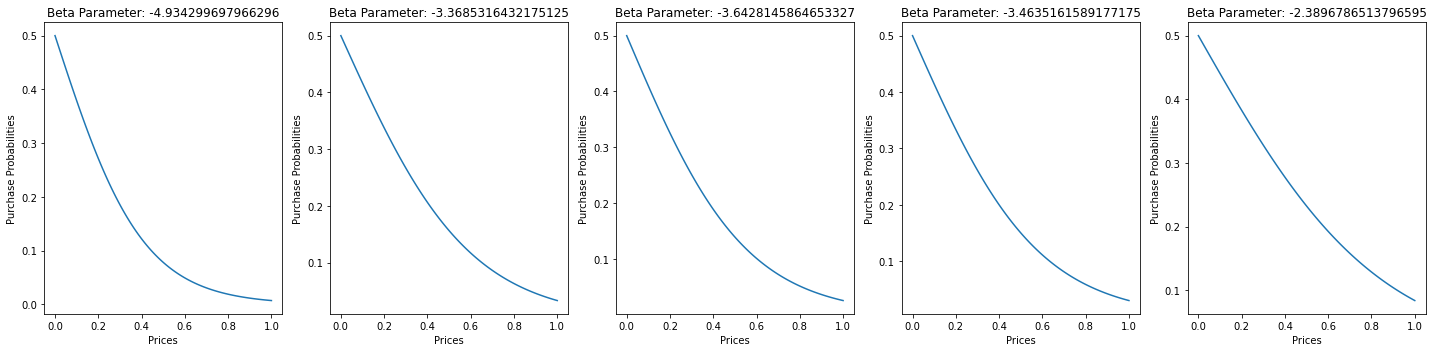

In [96]:
# Plot of the purchase probability when beta jumps
PurchaseProbabilityLogit_plot(beta_parameters, jump_days)

**Comment:**  
Here the changes in the purchase probability curve are more visible, the environment starts being adversarial, in fact UCB1 shows worst results.

### Purchase probability loses sense (S = 2, s = 0.01)

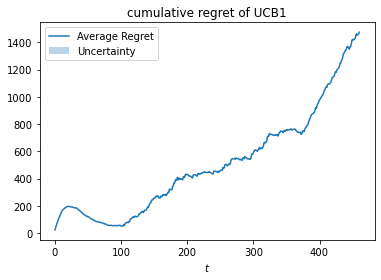

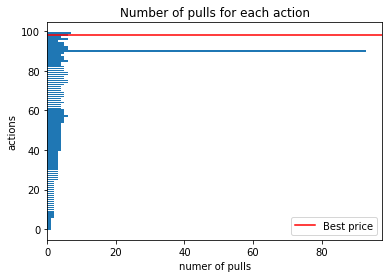

In [97]:
n_points = 100  # actions number 
cost = 0.2
n_customers = 200
max_price = 1.0

env = AdversarialPricingEnvironment_Logit(max_price=1.0, noise_level=0)
num_jumps, jump_lengths, T = env.simulate_jumps()

K = n_points
n_days = T

prices = np.linspace(0, max_price, n_points)


# Data generation -> each day the env samples for the prices of 'prices' the purchase probability, that is choosen randomly each day

prices_matrix = np.empty((n_days, n_points))  # Matrix to store prices for each day
probabilities_matrix = np.empty((n_days, n_points))  # Matrix to store purchase probabilities for each day
customers_number_matrix = np.empty((n_days, n_points))
rewards_matrix = np.empty((n_days, n_points))


# Loop through all the days
beta_parameters = np.array([-5]) # starting value for beta is -5
S = 2 # Varianace of the Normal for the beta_parameter variations during shock days 
s = 0.01 # Varianace of the Normal for the beta_parameter variations during normal days
jump_days = np.cumsum(jump_lengths)

for day in range(n_days):
    # Verify if it's a shock day
    if day in jump_days:
        beta_parameter_variation = np.random.normal(0, S)  # Varianza grande per gli shock
        beta_parameter = beta_parameters[-1] + beta_parameter_variation
    else:
        beta_parameter_variation = np.random.normal(0, s)  # Varianza piccola per i giorni normali
        beta_parameter = beta_parameters[-1] + beta_parameter_variation

    beta_parameters = np.append(beta_parameters, beta_parameter)
    # Data generation for the new beta
    day_prices, day_probabilities = env.generate_data(n_points, beta_parameter=beta_parameters[-1])
    
    # Price and probabilities memorization
    prices_matrix[day] = day_prices[:, 0]  
    probabilities_matrix[day] = day_probabilities  

# Probabilities_matrix -> customers_numbers -> rewards_matrix -> loss_seq
for i in range(n_days):
        for j in range(n_points):
            customers_number_matrix[i, j] = np.random.binomial(n_customers, probabilities_matrix[i, j])
            rewards_matrix[i, j] = customers_number_matrix[i, j]*(prices[j] - cost) # (Customers for that price (j) sampled in that day (i))*(that price(j) - cost)


best_arm_index = np.argmax(rewards_matrix.sum(axis=0))
best_arm = prices[best_arm_index]
clairvoyant_rewards = rewards_matrix[:, best_arm_index]

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    ucb_agent = UCB1Agent(K, T, range=15)

    agent_rewards = np.array([])

    for t in range(T):
        pi_t = ucb_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        r_t = rewards_matrix[t, pi_t]
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(100), ucb_agent.N_pulls)
plt.axhline(best_arm_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

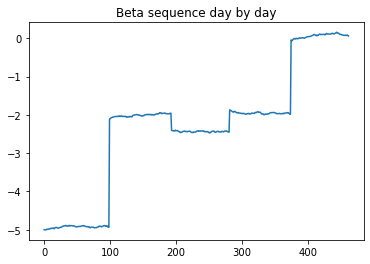

Beta: -4.934299697966296
Beta: -1.9545025076555258
Beta: -2.4522925111998566
Beta: -1.9800287897891482
Beta: 0.06249556155341586


In [68]:
# History of the beta parameter
plt.figure()
plt.plot(np.linspace(0, n_days, n_days+1),beta_parameters)
plt.title('Beta sequence day by day')
plt.show()

# Values of beta in the jumps
for jump_day in jump_days:
    print(f'Beta: {beta_parameters[int(jump_day)]}')

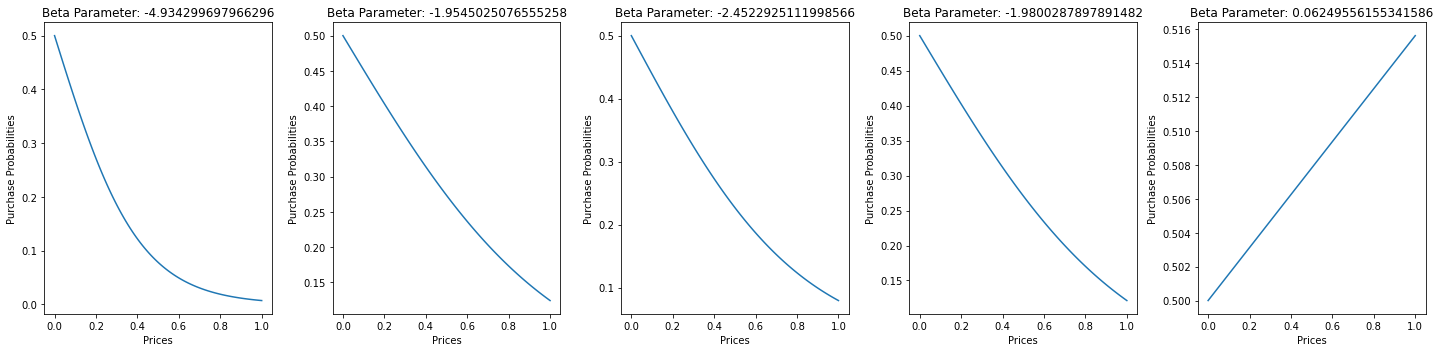

In [98]:
# Plot of the purchase probability when beta jumps
PurchaseProbabilityLogit_plot(beta_parameters, jump_days)

**Comment:**  
If we are unluck using S = 2 the beta parameter starts increasing to much and the purchase probability loses sense, since it become increasing in the price.

## Test on the Linear environment

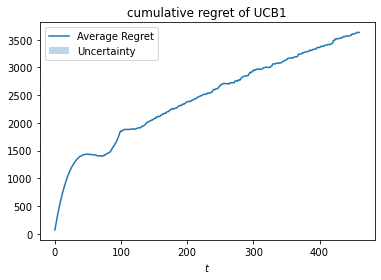

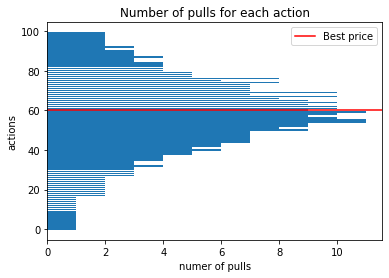

In [87]:
n_points = 100  # actions number 
cost = 0.2
n_customers = 200
max_price = 1.0

env = AdversarialPricingEnvironment_Linear(max_price=1.0, noise_level=0)
num_jumps, jump_lengths, T = env.simulate_jumps()

K = n_points
n_days = T

prices = np.linspace(0, max_price, n_points)


# Data generation -> each day the env samples for the prices of 'prices' the purchase probability, that is choosen randomly each day

prices_matrix = np.empty((n_days, n_points))  # Matrix to store prices for each day
probabilities_matrix = np.empty((n_days, n_points))  # Matrix to store purchase probabilities for each day
customers_number_matrix = np.empty((n_days, n_points))
rewards_matrix = np.empty((n_days, n_points))


# Loop through all the days
p_parameters = np.array([1]) # starting value for beta is -5
S = 1 # Varianace of the Normal for the beta_parameter variations during shock days 
s = 0.01 # Varianace of the Normal for the beta_parameter variations during normal days
jump_days = np.cumsum(jump_lengths)

for day in range(n_days):
    # Verify if it's a shock day
    if day in jump_days:
        p_parameter_variation = np.random.normal(0, S)  # Varianza grande per gli shock
        p_parameter = np.clip(p_parameters[-1] + p_parameter_variation, 0, 1)
    else:
        p_parameter_variation = np.random.normal(0, s)  # Varianza piccola per i giorni normali
        p_parameter = np.clip(p_parameters[-1] + p_parameter_variation, 0, 1)

    p_parameters = np.append(p_parameters, p_parameter)
    # Data generation for the new beta
    day_prices, day_probabilities = env.generate_data(n_points, p_parameter=p_parameters[-1])
    
    # Price and probabilities memorization
    prices_matrix[day] = day_prices[:, 0]  
    probabilities_matrix[day] = day_probabilities  

# Probabilities_matrix -> customers_numbers -> rewards_matrix -> loss_seq
for i in range(n_days):
        for j in range(n_points):
            customers_number_matrix[i, j] = np.random.binomial(n_customers, probabilities_matrix[i, j])
            rewards_matrix[i, j] = customers_number_matrix[i, j]*(prices[j] - cost) # (Customers for that price (j) sampled in that day (i))*(that price(j) - cost)


best_arm_index = np.argmax(rewards_matrix.sum(axis=0))
best_arm = prices[best_arm_index]
clairvoyant_rewards = rewards_matrix[:, best_arm_index]

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    ucb_agent = UCB1Agent(K, T, range=15)

    agent_rewards = np.array([])

    for t in range(T):
        pi_t = ucb_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        r_t = rewards_matrix[t, pi_t]
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(100), ucb_agent.N_pulls)
plt.axhline(best_arm_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

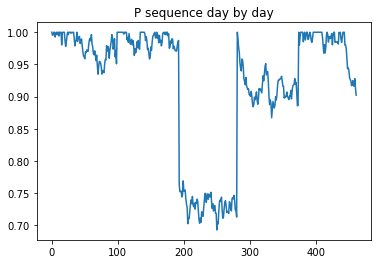

P: 0.9510468718543023
P: 0.9873204750819714
P: 0.7130375318341484
P: 0.8863331336845219
P: 0.9022609543470013


In [88]:
# History of the p parameter
plt.figure()
plt.plot(np.linspace(0, n_days, n_days+1),p_parameters)
plt.title('P sequence day by day')
plt.show()

# Values of beta in the jumps
for jump_day in jump_days:
    print(f'P: {p_parameters[int(jump_day)]}')

In [89]:
# Changes in the purchase probability function
def PurchaseProbabilityLinear_plot(beta_parameters, jump_days):
    n_points = 100
    prices = np.linspace(0, 1, n_points)
    alpha = 1
    beta = 1
    
    # Calcola il numero totale di subplot
    num_subplots = len(jump_days)
     
    # Crea la figura e gli assi dei subplot
    fig, axes = plt.subplots(1, num_subplots, figsize=(20, 5))
    axes = axes.flatten() 
    
    for i, jump_day in enumerate(jump_days):
        # Calcola le probabilità di acquisto usando il corrispondente beta_parameter per l'indice jump_day
        purchase_probabilities = p_parameters[int(jump_day)]*(alpha - beta*prices)    
        
        # Traccia il grafico
        ax = axes[i]
        ax.plot(prices, purchase_probabilities)
        ax.set_title(f' Parameter: {beta_parameters[int(jump_day)]}')
        ax.set_xlabel('Prices')
        ax.set_ylabel('Purchase Probabilities')

    # Aggiusta il layout
    plt.tight_layout()
    plt.show()     

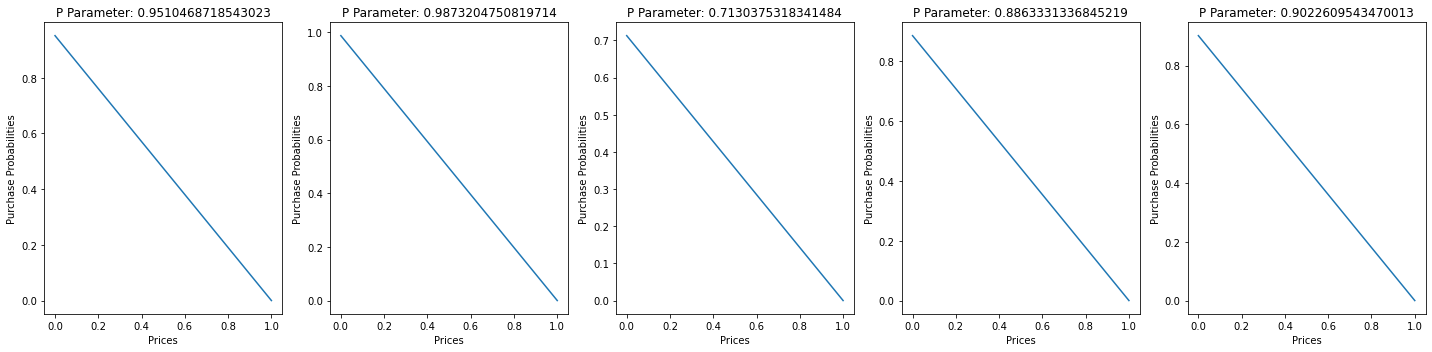

In [77]:
# Changes in the purchase probability plot
PurchaseProbabilityLinear_plot(p_parameters, jump_days)

**Comment:**   
Here every changes in 'S' and 's' doesn't affect that much the shape of the purchase probability, it remains the same, only rotated (change in slope and intercept at the same time) so probably again similar to the stochastic setting.

# EXP3

In [9]:
class EXP3Agent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

## Test on Logit enviroment

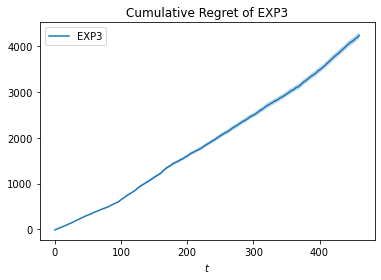

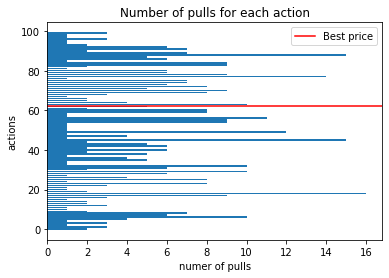

In [10]:
n_points = 100  # actions number 
cost = 0.2
n_customers = 200
max_price = 1.0

env = AdversarialPricingEnvironment_Logit(max_price=1.0, noise_level=0)
num_jumps, jump_lengths, T = env.simulate_jumps()

K = n_points
n_days = T

prices = np.linspace(0, max_price, n_points)

learning_rate = np.sqrt(np.log(K)/(K*T)) # we set the learning rate as prescribed by the theory (different from expert setting)

# Data generation -> each day the env samples for the prices of 'prices' the purchase probability, that is choosen randomly each day

prices_matrix = np.empty((n_days, n_points))  # Matrix to store prices for each day
probabilities_matrix = np.empty((n_days, n_points))  # Matrix to store purchase probabilities for each day
customers_number_matrix = np.empty((n_days, n_points))
rewards_matrix = np.empty((n_days, n_points))
loss_seq = np.empty((n_days, n_points))


# Loop through all the days
beta_parameters = np.array([-5]) # starting value for beta is -5
S = 1 # Varianace of the Normal for the beta_parameter variations during shock days 
s = 0.01 # Varianace of the Normal for the beta_parameter variations during normal days
jump_days = np.cumsum(jump_lengths)

for day in range(n_days):
    # Verify if it's a shock day
    if day in jump_days:
        beta_parameter_variation = np.random.normal(0, S)  # Varianza grande per gli shock
        beta_parameter = beta_parameters[-1] + beta_parameter_variation
    else:
        beta_parameter_variation = np.random.normal(0, s)  # Varianza piccola per i giorni normali
        beta_parameter = beta_parameters[-1] + beta_parameter_variation

    beta_parameters = np.append(beta_parameters, beta_parameter)
    # Data generation for the new beta
    day_prices, day_probabilities = env.generate_data(n_points, beta_parameter=beta_parameters[-1])
    
    # Price and probabilities memorization
    prices_matrix[day] = day_prices[:, 0]  
    probabilities_matrix[day] = day_probabilities  

# Probabilities_matrix -> customers_numbers -> rewards_matrix -> loss_seq
for i in range(n_days):
        for j in range(n_points):
            customers_number_matrix[i, j] = np.random.binomial(n_customers, probabilities_matrix[i, j])
            rewards_matrix[i, j] = customers_number_matrix[i, j]*(prices[j] - cost) # (Customers for that price (j) sampled in that day (i))*(that price(j) - cost)

max_reward = (max_price - cost) * n_customers
loss_seq = max_reward - rewards_matrix

best_arm_index = np.argmin(loss_seq.sum(axis=0))
best_arm = prices_matrix[0, best_arm_index]
clairvoyant_losses = loss_seq[:, best_arm_index]


n_trials = 100

exp3_regret_per_trial = []
# we keep the loss sequence fixed, we will only observe uncertainty due to algorithm's randomizations
for trial in range(n_trials):
    agent = EXP3Agent(K, learning_rate)
    
    expected_agent_losses = np.array([])
    for t in range(T):
        a_t = agent.pull_arm()
        l_t = loss_seq[t, a_t]
        agent.update(l_t)
        # logging
        expected_agent_losses = np.append(expected_agent_losses,
                                        np.dot(agent.x_t,
                                        loss_seq[t-1,:]))

    cumulative_regret = np.cumsum(expected_agent_losses-clairvoyant_losses)
    exp3_regret_per_trial.append(cumulative_regret)

exp3_regret_per_trial = np.array(exp3_regret_per_trial)

exp3_average_regret = exp3_regret_per_trial.mean(axis=0)
exp3_regret_sd = exp3_regret_per_trial.std(axis=0)

plt.plot(np.arange(T), exp3_average_regret, label='EXP3')
plt.title('Cumulative Regret of EXP3')
plt.fill_between(np.arange(T),
                exp3_average_regret-exp3_regret_sd/np.sqrt(n_trials),
                exp3_average_regret+exp3_regret_sd/np.sqrt(n_trials),
                alpha=0.3)
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(K), agent.N_pulls)
plt.axhline(best_arm_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show()


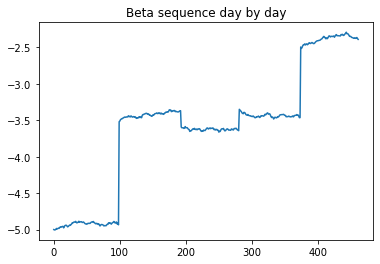

In [11]:
plt.figure()
plt.plot(np.linspace(0, n_days, n_days+1),beta_parameters)
plt.title('Beta sequence day by day')
plt.show()

## Test on Linear environment

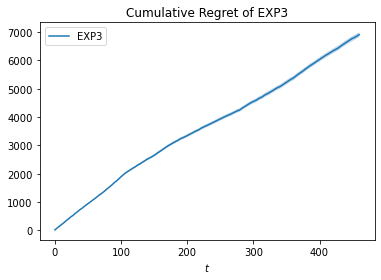

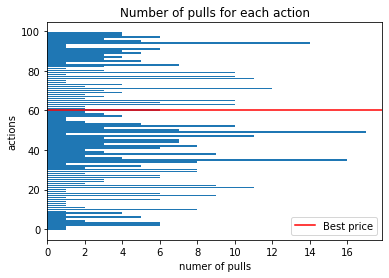

In [12]:
n_points = 100  # actions number 
cost = 0.2
n_customers = 200
max_price = 1.0

env = AdversarialPricingEnvironment_Linear(max_price=1.0, noise_level=0)
num_jumps, jump_lengths, T = env.simulate_jumps()

K = n_points
n_days = T

prices = np.linspace(0, max_price, n_points)

learning_rate = np.sqrt(np.log(K)/(K*T)) # we set the learning rate as prescribed by the theory (different from expert setting)

# Data generation -> each day the env samples for the prices of 'prices' the purchase probability, that is choosen randomly each day

prices_matrix = np.empty((n_days, n_points))  # Matrix to store prices for each day
probabilities_matrix = np.empty((n_days, n_points))  # Matrix to store purchase probabilities for each day
customers_number_matrix = np.empty((n_days, n_points))
rewards_matrix = np.empty((n_days, n_points))
loss_seq = np.empty((n_days, n_points))


# Loop through all the days
p_parameters = np.array([1]) # starting value for beta is -5
S = 1 # Varianace of the Normal for the beta_parameter variations during shock days 
s = 0.01 # Varianace of the Normal for the beta_parameter variations during normal days
jump_days = np.cumsum(jump_lengths)

for day in range(n_days):
    # Verify if it's a shock day
    if day in jump_days:
        p_parameter_variation = np.random.normal(0, S)  # Varianza grande per gli shock
        p_parameter = np.clip(p_parameters[-1] + p_parameter_variation, 0, 1)
    else:
        p_parameter_variation = np.random.normal(0, s)  # Varianza grande per gli shock
        p_parameter = np.clip(p_parameters[-1] + p_parameter_variation, 0, 1)
        
    p_parameters = np.append(p_parameters, p_parameter)
    # Data generation for the new beta
    day_prices, day_probabilities = env.generate_data(n_points, p_parameter=p_parameters[-1])
    
    # Price and probabilities memorization
    prices_matrix[day] = day_prices[:, 0]  
    probabilities_matrix[day] = day_probabilities  

# Probabilities_matrix -> customers_numbers -> rewards_matrix -> loss_seq
for i in range(n_days):
        for j in range(n_points):
            customers_number_matrix[i, j] = np.random.binomial(n_customers, probabilities_matrix[i, j])
            rewards_matrix[i, j] = customers_number_matrix[i, j]*(prices[j] - cost) # (Customers for that price (j) sampled in that day (i))*(that price(j) - cost)

max_reward = (max_price - cost) * n_customers
loss_seq = max_reward - rewards_matrix

best_arm_index = np.argmin(loss_seq.sum(axis=0))
best_arm = prices_matrix[0, best_arm_index]
clairvoyant_losses = loss_seq[:, best_arm_index]


n_trials = 100

exp3_regret_per_trial = []
# we keep the loss sequence fixed, we will only observe uncertainty due to algorithm's randomizations
for trial in range(n_trials):
    agent = EXP3Agent(K, learning_rate)
    
    expected_agent_losses = np.array([])
    for t in range(T):
        a_t = agent.pull_arm()
        l_t = loss_seq[t, a_t]
        agent.update(l_t)
        # logging
        expected_agent_losses = np.append(expected_agent_losses,
                                        np.dot(agent.x_t,
                                        loss_seq[t-1,:]))

    cumulative_regret = np.cumsum(expected_agent_losses-clairvoyant_losses)
    exp3_regret_per_trial.append(cumulative_regret)

exp3_regret_per_trial = np.array(exp3_regret_per_trial)

exp3_average_regret = exp3_regret_per_trial.mean(axis=0)
exp3_regret_sd = exp3_regret_per_trial.std(axis=0)

plt.plot(np.arange(T), exp3_average_regret, label='EXP3')
plt.title('Cumulative Regret of EXP3')
plt.fill_between(np.arange(T),
                exp3_average_regret-exp3_regret_sd/np.sqrt(n_trials),
                exp3_average_regret+exp3_regret_sd/np.sqrt(n_trials),
                alpha=0.3)
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(K), agent.N_pulls)
plt.axhline(best_arm_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show()


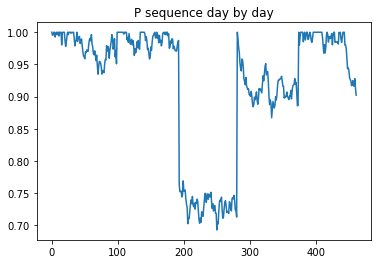

In [13]:
# History of the p parameter
plt.figure()
plt.plot(np.linspace(0, n_days, n_days+1),p_parameters)
plt.title('P sequence day by day')
plt.show()